In [44]:
#모듈 임포트
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Input, LeakyReLU, InputLayer, Flatten
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import re
from time import time

In [62]:
#########데이터 로드##########
# defining the size of image
SIZE = 256

sk_path = 'D:/resizeimg/resizesk'
sk_array = []

dk_path = 'D:/resizeimg/resizedk'
dk_array = []

sk_file = os.listdir(sk_path)
dk_file = os.listdir(dk_path)

for i in tqdm(sk_file):
    image = cv2.imread(sk_path + '/' + i, 1)

    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resizing images
    image = cv2.resize(image, (SIZE, SIZE))

    # normalizing image
    image = image.astype('float32') / 255.0

    #appending normal normal image
    sk_array.append(img_to_array(image))


for i in tqdm(dk_file):
    image = cv2.imread(dk_path + '/' + i, 1)

    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resizing images
    image = cv2.resize(image, (SIZE, SIZE))

    # normalizing image
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    dk_array.append(img_to_array(image))

# 이미지 사이즈 확인
print("Total number of sketch images:",len(sk_array))
print("Total number of shadow images:",len(dk_array))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 641.62it/s]

Total number of sketch images: 375
Total number of shadow images: 375


In [63]:
#Slicing and reshaping
train_dk_image = dk_array[:300]
train_sk_image = sk_array[:300]
test_dk_image = dk_array[300:]
test_sk_image = sk_array[300:]

In [64]:
len(train_dk_image)

300

In [65]:
# reshaping
train_dk_image = np.reshape(train_dk_image,(len(train_dk_image),SIZE,SIZE,3))
train_sk_image = np.reshape(train_sk_image, (len(train_sk_image),SIZE,SIZE,3))
print('Train dk image shape:',train_dk_image.shape)
test_dk_image = np.reshape(test_dk_image,(len(test_dk_image),SIZE,SIZE,3))
test_sk_image = np.reshape(test_sk_image, (len(test_sk_image),SIZE,SIZE,3))
print('Test dk image shape',test_dk_image.shape)

Train dk image shape: (300, 256, 256, 3)
Test dk image shape (75, 256, 256, 3)


In [52]:
#정규화
train_dk_image = train_dk_image/255.0
train_sk_image = train_sk_image/255.0
test_dk_image = test_dk_image/255.0
test_sk_image = test_sk_image/255.0

In [52]:
#정규화
train_dk_image = train_dk_image
train_sk_image = train_sk_image
test_dk_image = test_dk_image
test_sk_image = test_sk_image

In [66]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 20)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Sketches ', color = 'black', fontsize = 20)
    plt.imshow(sketches)
   
    plt.show()

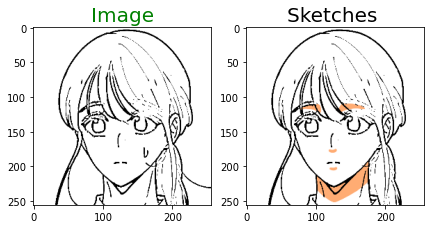

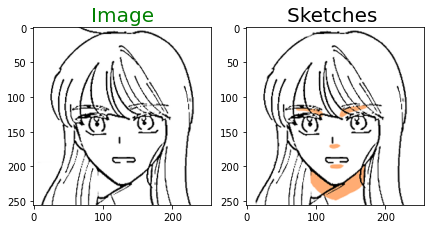

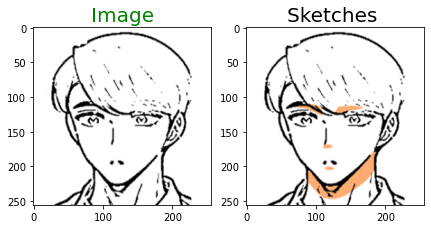

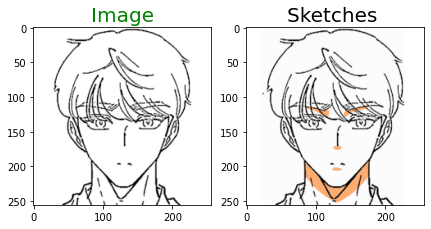

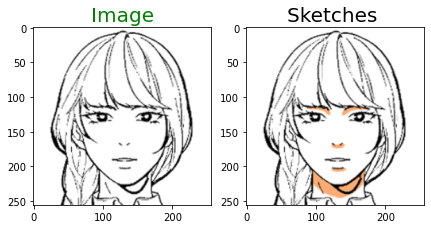

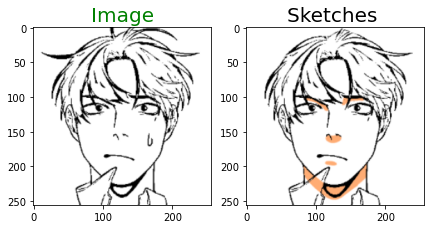

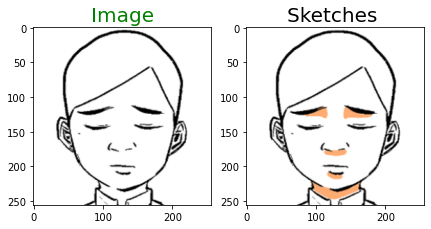

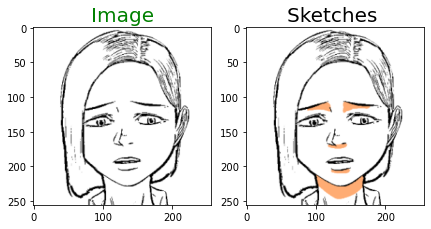

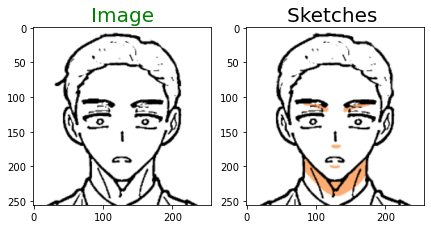

In [67]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(sk_array[i],dk_array[i])

In [68]:
##########모델링############

#Downsample layer
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

#Upsample layer
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU())
    return upsample


In [69]:

#Model01    kaggle 모델
def model():
    encoder_input = keras.Input(shape=(SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32, 4)(x)
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)

    encoder_output = downsample(512, 4)(x)

    decoder_input = upsample(512, 4, True)(encoder_output)
    x = upsample(256, 4, False)(decoder_input)
    x = upsample(128, 4, True)(x)
    x = upsample(64, 4)(x)
    x = upsample(32, 4)(x)
    x = upsample(16, 4)(x)
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(1, 1), padding='valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='valid')(x)

    return tf.keras.Model(encoder_input, decoder_output)


In [76]:

#Model02    정확도 0.95
def model():
    encoder_input = keras.Input(shape=(SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32, 4)(x)
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4, False)(x)

    encoder_output = downsample(512, 4)(x)

    decoder_input = upsample(512, 4, True)(encoder_output)
    x = upsample(256, 4, False)(decoder_input)
    x = upsample(128, 4, True)(x)
    x = upsample(64, 4)(x)
    x = upsample(32, 4, True)(x)
    x = upsample(16, 4)(x)
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(1, 1), padding='valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='valid')(x)

    return tf.keras.Model(encoder_input, decoder_output)


In [159]:

#Model03     밑그림 잘그림
#총 학습 시간: 964.65524
def model():
    encoder_input = keras.Input(shape=(SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32, 4)(x)
    x = downsample(64, 4, False)(x)
    #x = downsample(128, 4)(x)
    #x = downsample(256, 4, False)(x)

    encoder_output = downsample(128, 4)(x)

    decoder_input = upsample(128, 4, True)(encoder_output)
    x = upsample(64, 4, False)(decoder_input)
    x = upsample(32, 4, True)(x)
    x = upsample(16, 4)(x)
    #x = upsample(32, 4, True)(x)
    #x = upsample(16, 4)(x)
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(1, 1), padding='valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='valid')(x)

    return tf.keras.Model(encoder_input, decoder_output)


In [147]:

#Model04     밑그림 애매, 그림자 약하게
#총 학습 시간: 1158.89224
def model():
    encoder_input = keras.Input(shape=(SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32, 4)(x)
    x = downsample(64, 4, False)(x)
    x = downsample(128, 4)(x)
    #x = downsample(256, 4, False)(x)

    encoder_output = downsample(256, 4)(x)

    decoder_input = upsample(256, 4, True)(encoder_output)
    x = upsample(128, 4, False)(decoder_input)
    x = upsample(64, 4, True)(x)
    x = upsample(32, 4)(x)
    x = upsample(16, 4, True)(x)
    #x = upsample(16, 4)(x)
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(1, 1), padding='valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='valid')(x)

    return tf.keras.Model(encoder_input, decoder_output)


In [152]:

#Model05     밑그림 
#총 학습 시간: 629.63초
def model():
    encoder_input = keras.Input(shape=(SIZE, SIZE, 3))
    x = downsample(8, 4, False)(encoder_input)
    x = downsample(16, 4)(x)

    encoder_output = downsample(32, 4)(x)

    decoder_input = upsample(32, 4, True)(encoder_output)
    x = upsample(16, 4, False)(decoder_input)
    x = upsample(8, 4, True)(x)

    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(1, 1), padding='valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='valid')(x)

    return tf.keras.Model(encoder_input, decoder_output)


In [34]:
'''
##########모델링############
model = Sequential()
model.add(InputLayer(input_shape=(SIZE,SIZE,3)))
model.add(Conv2D(8,4,1,padding='same', activation='relu'))
model.add(MaxPooling2D(2))
#model.add(LeakyReLU())
model.add(Conv2D(16,4,1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
#model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
'''

In [160]:
# to get summary of model
model = model()
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_141 (Sequential)  (None, 127, 127, 16)      768       
_________________________________________________________________
sequential_142 (Sequential)  (None, 62, 62, 32)        8320      
_________________________________________________________________
sequential_143 (Sequential)  (None, 30, 30, 64)        32768     
_________________________________________________________________
sequential_144 (Sequential)  (None, 14, 14, 128)       131584    
_________________________________________________________________
sequential_145 (Sequential)  (None, 30, 30, 128)       262144    
_________________________________________________________________
sequential_146 (Sequential)  (None, 62, 62, 64)        131

In [161]:
#Compiling and Fitting our model
begin = time()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_sk_image, train_dk_image, epochs = 100, verbose = 1)

end = time()
print('총 학습 시간: {:.2f}초'.format(end-begin))

Epoch 1/100
10/10 [==============================] - 10s 944ms/step - loss: 0.8378 - acc: 0.1817
Epoch 2/100
10/10 [==============================] - 9s 935ms/step - loss: 0.4152 - acc: 0.5633
Epoch 3/100
10/10 [==============================] - 10s 955ms/step - loss: 0.2970 - acc: 0.3690
Epoch 4/100
10/10 [==============================] - 10s 954ms/step - loss: 0.2416 - acc: 0.3919
Epoch 5/100
10/10 [==============================] - 10s 950ms/step - loss: 0.2110 - acc: 0.3570
Epoch 6/100
10/10 [==============================] - 10s 949ms/step - loss: 0.1936 - acc: 0.3978
Epoch 7/100
10/10 [==============================] - 10s 945ms/step - loss: 0.1796 - acc: 0.3672
Epoch 8/100
10/10 [==============================] - 9s 936ms/step - loss: 0.1718 - acc: 0.3839
Epoch 9/100
10/10 [==============================] - 10s 956ms/step - loss: 0.1830 - acc: 0.3939
Epoch 10/100
10/10 [==============================] - 10s 948ms/step - loss: 0.1611 - acc: 0.3900
Epoch 11/100
10/10 [===========

In [157]:
#Evaluating our model
prediction_on_test_data = model.evaluate(test_sk_image, test_dk_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

3/3 [==============================] - 1s 185ms/step - loss: 0.0756 - acc: 0.4386
Loss:  0.07559055835008621
Accuracy:  43.9


IndexError: index 80 is out of bounds for axis 0 with size 75

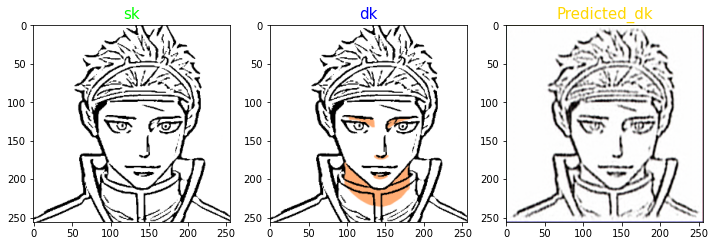

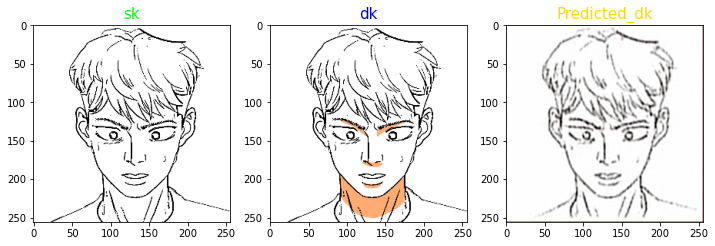

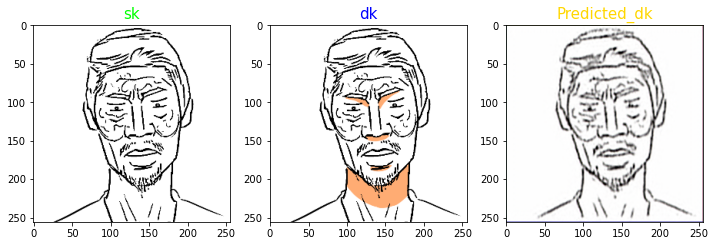

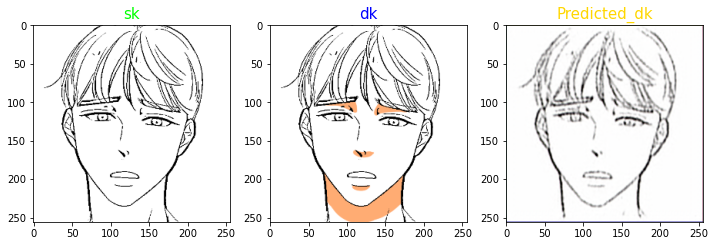

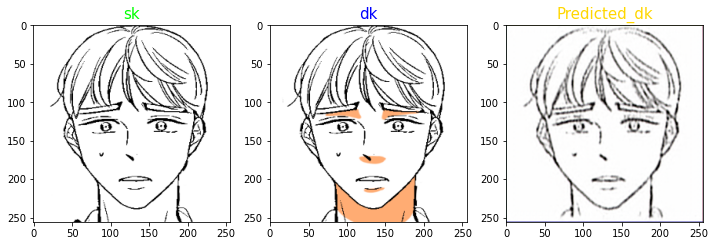

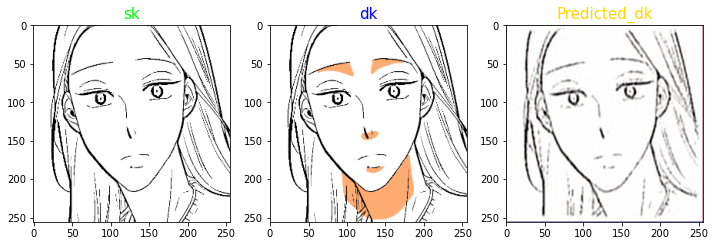

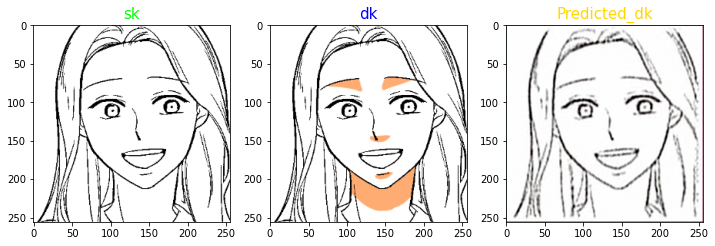

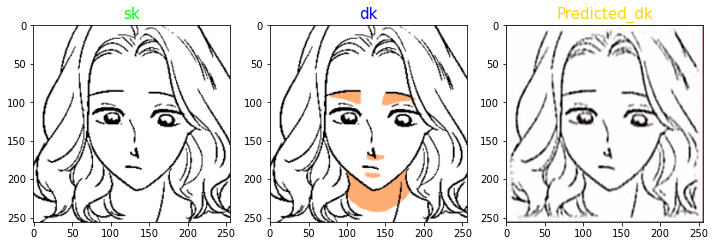

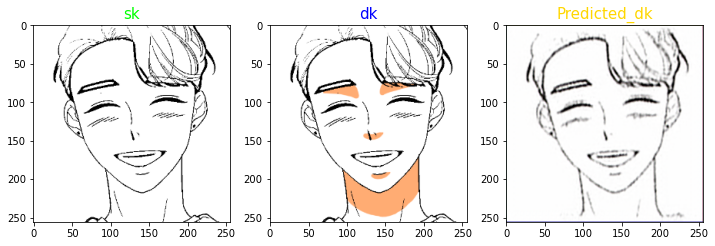

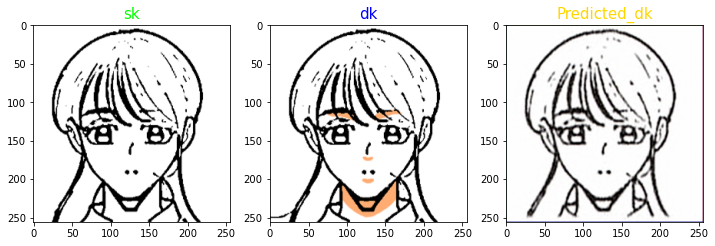

In [158]:
#Plotting our predicted sketch along with real sketch
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("sk",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("dk",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted_dk",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

ls = [i for i in range(0,95,8)]
for i in ls:
    predicted =np.clip(model.predict(test_sk_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    #predicted = model.predict(test_sk_image[i].reshape(1,SIZE,SIZE,3)).reshape(SIZE,SIZE,3)
    show_images(test_sk_image[i],test_dk_image[i],(predicted*255).astype(np.uint8))